## 010 Normed vs non-normed prototype performance (single subject)

Date: 26.Jul.2022

### Purpose

Create normed and non-normed prototype classes and compare their performances.

### Outline of Plan

1. Visually inspect cravings across subjects to select a good subject to fit.
2. Consider a delta craving model.
3. Specify normed and non-normed prototypes. List all assumptions for each.
4. Specify RW versions each prototype and compare performance.

### What we did in this notebook

1. Comparison between normed and non-normed models reveals that normed models generally perform better.
2. We are losing the information about the intercept of the craving ratings (mean rating) in the estimation, but we can perform a separate analysis to calculate the differences in mean craving and variation in craving (model-free analysis)
3. A craving sigma parameter has been added to the NormPrototype to adaptively estimate the variance in the predicted cravings. This doesn't increase the estimation time or effectiveness. Recommend preserving this parameter.
4. Tried adding mean craving back to normed cravings to estimate w0 with mean, but this leads to poorer estimation. Not recommended.
5. Plotted true cravings per subject to select a "good" subject to estimate. Subject 15 (money) chosen here, subject 7 (other) is good too.

In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Normed prototype class

Assumptions:
1. Both non-normed and normed cravings are calculated and stored
2. Craving inds are calculated
3. Craving means and st. dev. are calculated
4. Beta is the first variable specified, only one beta, and is a required argument
5. Non-sequences in aesara loop DO NOT include beta
6. Sigma in craving_lik equals 1
7. MAJOR DIFF: normed craving retrieved in fit function

In [148]:
class NormPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[*args])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        # cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        # craving_inds = np.squeeze(np.argwhere(cravings>-1))
        # mask = np.ones(len(craving_inds), dtype=bool)
        # mask[12] = False
        # craving_inds = craving_inds[mask]
        # cravings = cravings[craving_inds]
        # norm_cravings = stats.zscore(cravings)
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, norm_cravings = self._load_act_rew_craving(pid_num, block)
        with pm.Model() as model:
            priors = self._define_priors()
            craving_sig = pm.Exponential('craving_sig', 2)
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[self.craving_inds-1], sigma=craving_sig, observed=norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Non-normed prototype class

Assumptions:
1. Both non-normed and normed cravings are calculated and stored
2. Craving inds are calculated
3. Craving means and st. dev. are calculated
4. Beta is the first variable specified, only one beta, and is a required argument
5. Non-sequences in aesara loop DO NOT include beta
6. Sigma in craving_lik equals 1
7. MAJOR DIFF: non-normed craving retrieved in fit function.
8. MAJOR DIFF: remember to set different priors for fitting. E.g. set w0 ~ N(25, 2) or something

In [147]:
class NonNormPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[*args])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        # cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        # craving_inds = np.squeeze(np.argwhere(cravings>-1))
        # mask = np.ones(len(craving_inds), dtype=bool)
        # mask[12] = False
        # craving_inds = craving_inds[mask]
        # cravings = cravings[craving_inds]
        # norm_cravings = stats.zscore(cravings)
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, standard_cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            craving_sig = pm.Exponential('craving_sig', 2)
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[self.craving_inds-1], sigma=craving_sig, observed=standard_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Inheritance models

In [149]:
class Norm_Passive_RW_EVRPE(NormPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Norm_Passive_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        Qs = at.set_subtensor(Qs[-1], w0 + w1 * Qs[a] + w2 * pe) 
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [150]:
class Standard_Passive_RW_EVRPE(NonNormPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Standard_Passive_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        Qs = at.set_subtensor(Qs[-1], w0 + w1 * Qs[a] + w2 * pe) 
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=2)
        weight_one = pm.Normal('weight_one', mu=0, sigma=2)
        weight_two = pm.Normal('weight_two', mu=0, sigma=2)
        return beta, alpha, weight_zero, weight_one, weight_two

In [151]:
norm_model = Norm_Passive_RW_EVRPE(longform, df_summary, project_dir)
nonnorm_model = Standard_Passive_RW_EVRPE(longform, df_summary, project_dir)

## Visualize cravings

(-3.0, 3.0)

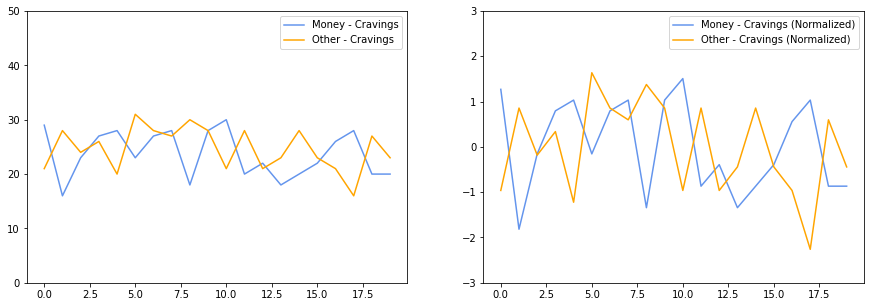

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
pid_num = 16
sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, pid_num])), 
    y=norm_model.cravings[0, pid_num], 
    color='cornflowerblue', ax=ax[0], label='Money - Cravings'
)    
sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, pid_num])), 
    y=norm_model.norm_cravings[0, pid_num], 
    ax=ax[1], color='cornflowerblue', label='Money - Cravings (Normalized)'
)
sns.lineplot(
    x=np.arange(len(norm_model.cravings[1, pid_num])), 
    y=norm_model.cravings[1, pid_num], 
    color='orange', ax=ax[0], label='Other - Cravings'
)    
sns.lineplot(
    x=np.arange(len(norm_model.cravings[1, pid_num])), 
    y=norm_model.norm_cravings[1, pid_num], 
    ax=ax[1], color='orange', label='Other - Cravings (Normalized)'
)
ax[0].set_ylim(0, 50)
ax[1].set_ylim(-3, 3)

## Fit models

In [153]:
norm_model.fit(15, 'money')
nonnorm_model.fit(15, 'money')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [craving_sig]


/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


## Output posterior

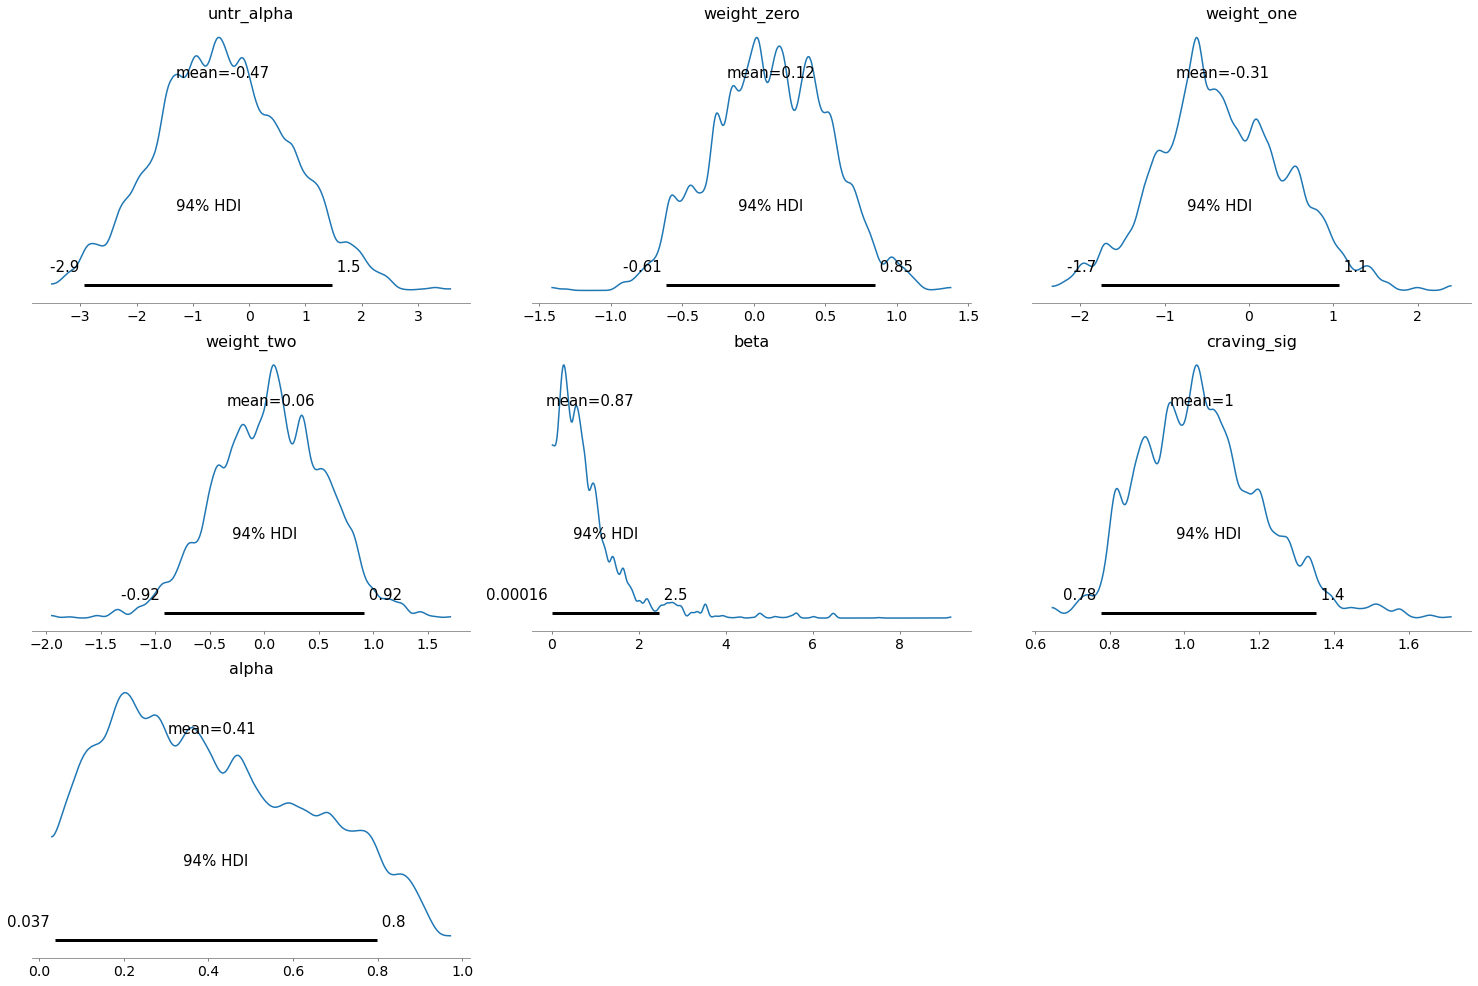

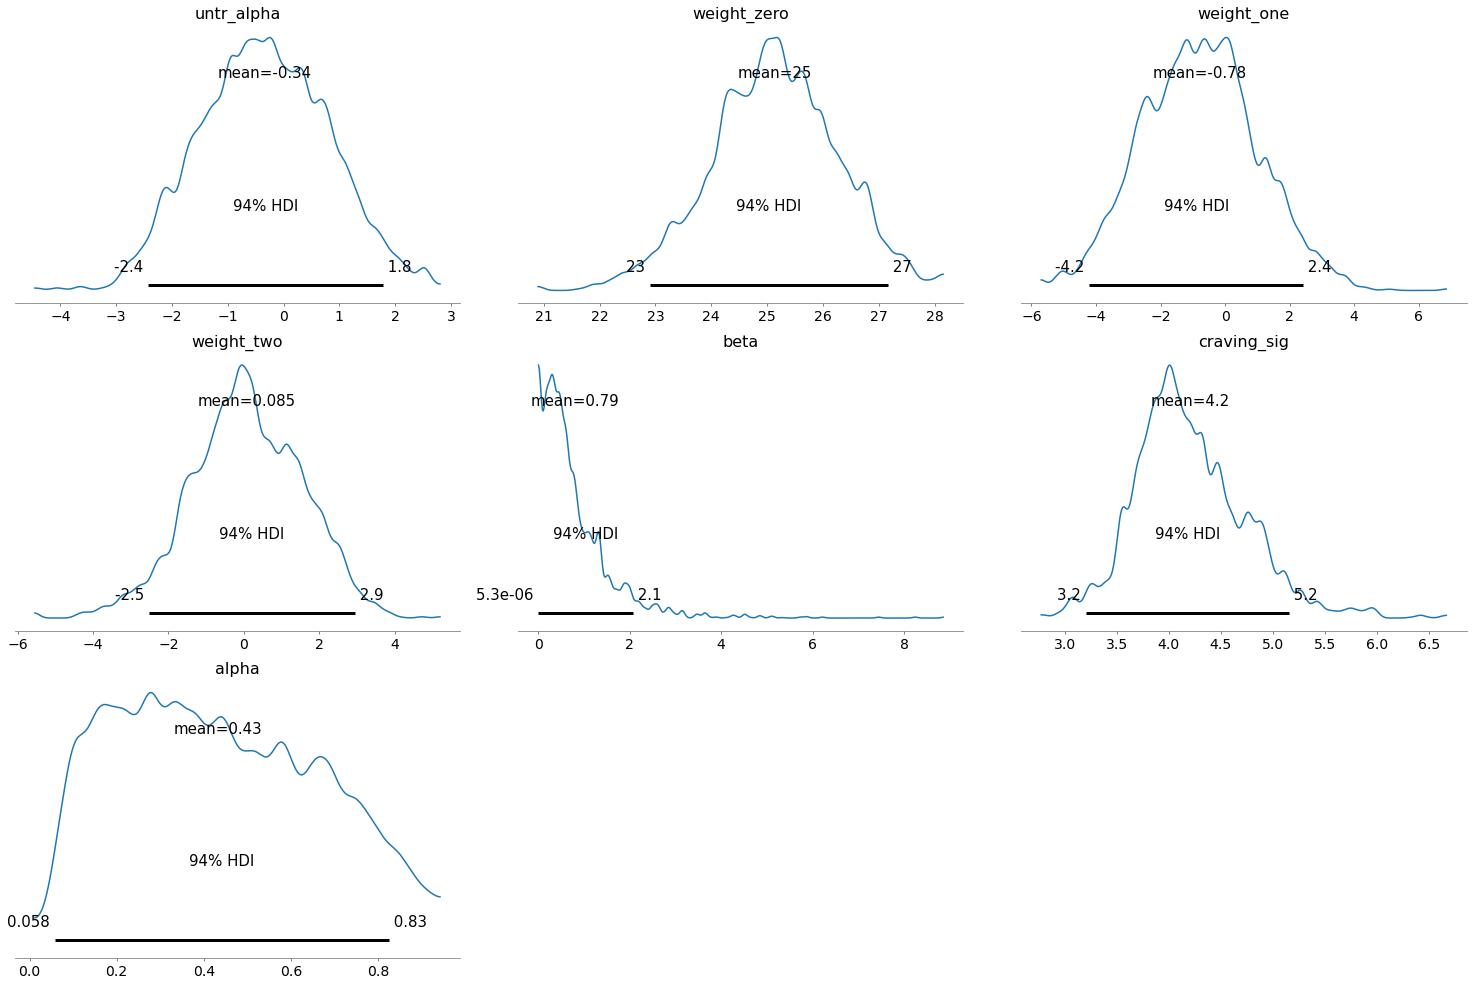

In [154]:
az.plot_posterior(norm_model.traces['money'][pid_list[15]])
plt.tight_layout()
az.plot_posterior(nonnorm_model.traces['money'][pid_list[15]])
plt.tight_layout()


<AxesSubplot:>

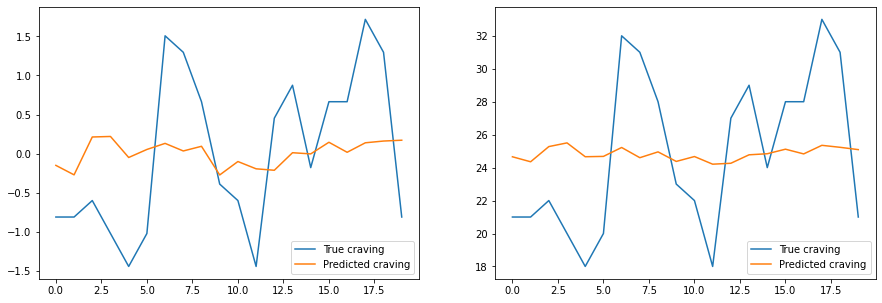

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, 12])),
    y=norm_model.norm_cravings[0, 15],
    label='True craving',
    ax=ax[0],
)
sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, 12])),
    y=norm_model.traces['money'][pid_list[15]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[0],
)
sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, 12])),
    y=nonnorm_model.cravings[0, 15],
    label='True craving',
    ax=ax[1],
)
sns.lineplot(
    x=np.arange(len(norm_model.norm_cravings[0, 12])),
    y=nonnorm_model.traces['money'][pid_list[15]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[1],
)


## Model comparison of EV and EVRPE

In [156]:
model_comp = az.compare({
        'Norm_Passive_RW_EVRPE': norm_model.traces['money'][pid_list[15]],
        'Standard_Passive_RW_EVRPE': nonnorm_model.traces['money'][pid_list[15]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Norm_Passive_RW_EVRPE,0,-30.797639,2.563736,0.000000,1.000000e+00,1.799961,0.000000,False,log
Standard_Passive_RW_EVRPE,1,-61.976231,2.514669,31.178592,1.922018e-12,2.535880,0.793104,True,log


<AxesSubplot:xlabel='Log'>

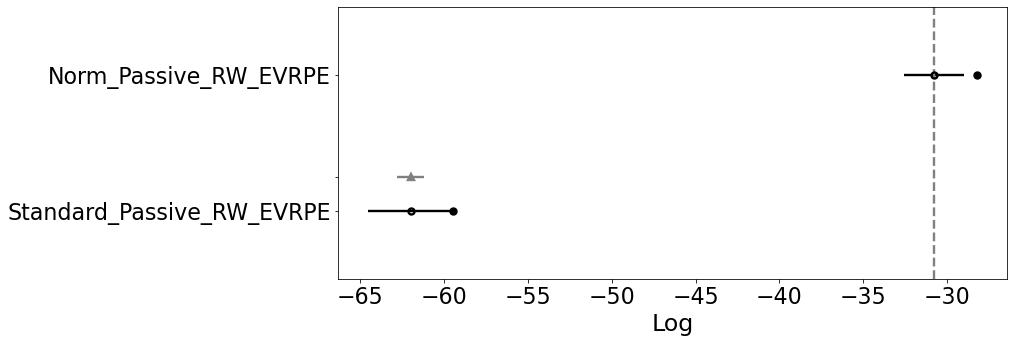

In [157]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))